In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os
import numpy as np
from collections import namedtuple
import cv2
from pathlib import Path
import argparse
import os
import csv
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow import keras

# pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

In [2]:
### 실행결과 동일하게(완전 일치하지는 않음)
tf.keras.utils.set_random_seed(42)
### 텐서 연산 고정(완전 일치하지는 않음)
tf.config.experimental.enable_op_determinism()

In [3]:
# data = 원본데이터 | data2 = 원본데이터 복붙 | data3 = 우리가 측정한 데이터
folder_path_2 = "./data/이상(흡연)"
folder_path_3 = "./data/이상(노흡연)"

In [4]:
import os
import pandas as pd

def concat(path):
    file_lst = os.listdir(path)
    df_list = []
    
    for file in file_lst:
        file_name = os.path.join(path, file)
        df = pd.read_csv(file_name)
        df = df[df.NUMOFBODIES != 0].reset_index(drop=True)
        
        # 각 열을 순차적으로 뺍니다.
        for i in range(1, df.shape[1]-1):  # 첫 번째 열을 제외하고 시작
            # 변환: 문자열이 포함된 열을 숫자로 변환
            df.iloc[:, i] = pd.to_numeric(df.iloc[:, i], errors='coerce')
            df.iloc[:, i+1] = pd.to_numeric(df.iloc[:, i+1], errors='coerce')
            
            # 원래의 열에 연산 결과 할당
            df.iloc[:-1, i] = df.iloc[1:, i].values - df.iloc[:-1, i].values
        
        # 마지막 행 제거
        df = df.iloc[:-1, :]
        
        # 길이가 610보다 짧은 경우 패딩 추가
        if len(df) < 610:
            pad_length = 610 - len(df)
            pad_df = pd.DataFrame(0, index=range(len(df), 610), columns=df.columns)
            df = pd.concat([df, pad_df])
        df['index_num'] = df.index
        
        df_list.append(df)

    return df_list


In [5]:
smoke_mer = concat(folder_path_2)
no_mer = concat(folder_path_3)

In [6]:
smoke_mer = pd.concat(smoke_mer, ignore_index=True)
no_mer = pd.concat(no_mer, ignore_index=True)

In [7]:
# 예측할 행위를 1, 나머지를 0으로 라벨링해서 11개 모델 다 따로 생성하기
# 정상행동 = 0, 이상행동 = 1
smoke_mer['LABEL'] = 1      
no_mer['LABEL'] = 0      

In [8]:
mer_lst = [
           no_mer,
           smoke_mer,]
full_data = pd.concat(mer_lst, ignore_index=True)
full_data.shape

(10980, 42)

In [9]:
full_data = full_data.drop(full_data.columns[1:14], axis=1)
full_data

,NUMOFBODIES,LEFT_SHOULDER_X,LEFT_SHOULDER_Y,RIGHT_SHOULDER_X,RIGHT_SHOULDER_Y,LEFT_ELBOW_X,LEFT_ELBOW_Y,RIGHT_ELBOW_X,RIGHT_ELBOW_Y,LEFT_WRIST_X,...,RIGHT_KNEE_X,RIGHT_KNEE_Y,LEFT_ANKLE_X,LEFT_ANKLE_Y,RIGHT_ANKLE_X,RIGHT_ANKLE_Y,HEAD_X,HEAD_Y,index_num,LABEL
0,1,89.0,-13.0,99.0,-11.0,111.0,-15.0,90.0,-8.0,127.0,...,110.0,-26.0,18.0,1.0,100.0,-25.0,93.4,146.6,0,0
1,1,33.0,-13.0,24.0,2.0,39.0,-14.0,27.0,5.0,49.0,...,87.0,33.0,-6.0,-12.0,159.0,16.0,23.8,138.8,1,0
2,1,6.0,-28.0,-5.0,17.0,11.0,-19.0,19.0,15.0,-7.0,...,17.0,-7.0,47.0,11.0,7.0,23.0,-23.6,132.4,2,0
3,1,1.0,-16.0,-10.0,1.0,19.0,-14.0,-8.0,-4.0,31.0,...,-13.0,-1.0,69.0,63.0,6.0,-22.0,-19.0,122.4,3,0
4,1,-19.0,-19.0,9.0,-27.0,-50.0,8.0,-6.0,-3.0,-106.0,...,-38.0,24.0,-80.0,20.0,1.0,34.0,-3.0,109.6,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10975,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,605,1
10976,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,606,1
10977,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,607,1
10978,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,608,1


In [10]:
data_without_label = full_data.drop(['LABEL'], axis=1)
label_data = full_data['LABEL']

In [11]:
data_without_label

,NUMOFBODIES,LEFT_SHOULDER_X,LEFT_SHOULDER_Y,RIGHT_SHOULDER_X,RIGHT_SHOULDER_Y,LEFT_ELBOW_X,LEFT_ELBOW_Y,RIGHT_ELBOW_X,RIGHT_ELBOW_Y,LEFT_WRIST_X,...,LEFT_KNEE_Y,RIGHT_KNEE_X,RIGHT_KNEE_Y,LEFT_ANKLE_X,LEFT_ANKLE_Y,RIGHT_ANKLE_X,RIGHT_ANKLE_Y,HEAD_X,HEAD_Y,index_num
0,1,89.0,-13.0,99.0,-11.0,111.0,-15.0,90.0,-8.0,127.0,...,-15.0,110.0,-26.0,18.0,1.0,100.0,-25.0,93.4,146.6,0
1,1,33.0,-13.0,24.0,2.0,39.0,-14.0,27.0,5.0,49.0,...,27.0,87.0,33.0,-6.0,-12.0,159.0,16.0,23.8,138.8,1
2,1,6.0,-28.0,-5.0,17.0,11.0,-19.0,19.0,15.0,-7.0,...,-10.0,17.0,-7.0,47.0,11.0,7.0,23.0,-23.6,132.4,2
3,1,1.0,-16.0,-10.0,1.0,19.0,-14.0,-8.0,-4.0,31.0,...,12.0,-13.0,-1.0,69.0,63.0,6.0,-22.0,-19.0,122.4,3
4,1,-19.0,-19.0,9.0,-27.0,-50.0,8.0,-6.0,-3.0,-106.0,...,22.0,-38.0,24.0,-80.0,20.0,1.0,34.0,-3.0,109.6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10975,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,605
10976,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,606
10977,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,607
10978,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,608


In [12]:
data_without_label['RIGHT_ANKLE_Y'][160]

-39.0

In [13]:
data_without_label.dtypes

NUMOFBODIES           int64
LEFT_SHOULDER_X     float64
LEFT_SHOULDER_Y     float64
RIGHT_SHOULDER_X    float64
RIGHT_SHOULDER_Y    float64
LEFT_ELBOW_X        float64
LEFT_ELBOW_Y        float64
RIGHT_ELBOW_X       float64
RIGHT_ELBOW_Y       float64
LEFT_WRIST_X        float64
LEFT_WRIST_Y        float64
RIGHT_WRIST_X       float64
RIGHT_WRIST_Y       float64
LEFT_HIP_X          float64
LEFT_HIP_Y          float64
RIGHT_HIP_X         float64
RIGHT_HIP_Y         float64
LEFT_KNEE_X         float64
LEFT_KNEE_Y         float64
RIGHT_KNEE_X        float64
RIGHT_KNEE_Y        float64
LEFT_ANKLE_X        float64
LEFT_ANKLE_Y        float64
RIGHT_ANKLE_X       float64
RIGHT_ANKLE_Y       float64
HEAD_X              float64
HEAD_Y              float64
index_num             int64
dtype: object

In [14]:
sequence_start_indices = full_data.index[full_data['index_num'] == 0].tolist()  # full_data에서 'index_num'이 0인 행의 인덱스를 리스트로 저장

# sequence_lengths = [sequence_start_indices[i] - sequence_start_indices[i-1] for i in range(1, len(sequence_start_indices))]  # sequence_start_indices의 각 요소와 그 이전 요소의 차이를 계산하여 sequence_lengths 리스트에 저장
# sequence_lengths.insert(0, sequence_start_indices[0])  # sequence_start_indices의 첫 번째 요소를 sequence_lengths 리스트의 첫 번째 위치에 삽입

# min_sequence_length = min(sequence_lengths)  # sequence_lengths 리스트에서 가장 작은 값을 min_sequence_length 변수에 저장

In [15]:
min_sequence_length = 610

In [16]:
len(sequence_start_indices)

18

In [17]:
X_sequences = []
y_sequences = []

# start indices를 순회하면서 sequence를 생성하기 위해 반복문 실행
for i in range(len(sequence_start_indices) - 1):
    start_index = sequence_start_indices[i]
    end_index = sequence_start_indices[i + 1]

    # sequence의 길이가 예상한 길이와 일치하는지 확인 후 추가
    if end_index - start_index == min_sequence_length:
        X_sequence = data_without_label.iloc[start_index:end_index].values
        y_sequence = label_data.iloc[start_index:end_index].values
        X_sequences.append(X_sequence)
        y_sequences.append(y_sequence[-1])  # sequence의 마지막 프레임의 레이블을 가져옴

# 리스트를 numpy 배열로 변환
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

X_sequences.shape, y_sequences.shape

((17, 610, 28), (17,))

In [139]:
y_sequences

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [67]:
# Check the unique values and their frequencies in y_sequences
y_unique_values, y_counts = np.unique(y_sequences, return_counts=True)

y_unique_values, y_counts


(array([0, 1], dtype=int64), array([8, 5], dtype=int64))

In [68]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X_sequences, y_sequences, test_size=0.3, random_state=48)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=48)

In [69]:
X_train.shape

(9, 610, 28)

In [ ]:
print(X_train.shape, y_train.shape)

In [ ]:
print(X_temp.shape, y_temp.shape)

In [ ]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_val = X_val.astype(np.float32)
y_val = y_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)


In [91]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(64, return_sequences=True),
    #tf.keras.layers.Dropout(0.3),
    #tf.keras.layers.LSTM(32),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 훈련 데이터에 대한 샘플 가중치 마스크 생성
# 패딩이 아닌 값은 1, 패딩된 값은 0
sample_weight_train = np.where(X_train != 0, 1, 0)
sample_weight_train = sample_weight_train.max(axis=-1)

# 각 시퀀스에 대한 평균 샘플 가중치 계산
sample_weight_train_avg = sample_weight_train.mean(axis=1)

In [98]:
# !!!!!행위마다 모델 이름 변경하기!!!!!
model_file_path = "./model/smoke_real.h5"
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_file_path, save_best_only = True)
# - 자동 훈련 멈추기 함수 사용 : 추가 훈련 epoch 3회, 가중치 업데이트
# - patience : 검증 손실의 최솟값에 도달한 후 중단하기 전에 기다려야 하는 epoch 수
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3,
                                                  restore_best_weights=True)

# 모델 훈련
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500,
                    batch_size=128, sample_weight=sample_weight_train_avg,
                    callbacks=[checkpoint_cb, early_stopping_cb])

# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Epoch 1/500
1/1 [==============================] - ETA: 0s - loss: nan - accuracy: 0.2222

KeyboardInterrupt: 

In [18]:
# 모델 불러오기
from keras.models import load_model
model1 = load_model('./model/smoke_last.h5')

In [19]:
X_sequences, y_sequences
X_val = X_sequences.astype(np.float32)
y_val = y_sequences.astype(np.float32)

In [20]:
# 유니크한 종속변수들을 얻습니다.
unique_targets = np.unique(y_val)

# 테스트 데이터에 대한 예측을 한 번만 수행
test_preds = model1.predict(X_val)
test_pred_idx = [np.argmax(pred) for pred in test_preds]

1/1 [==============================] - 1s 697ms/step


In [21]:
test_pred_idx

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

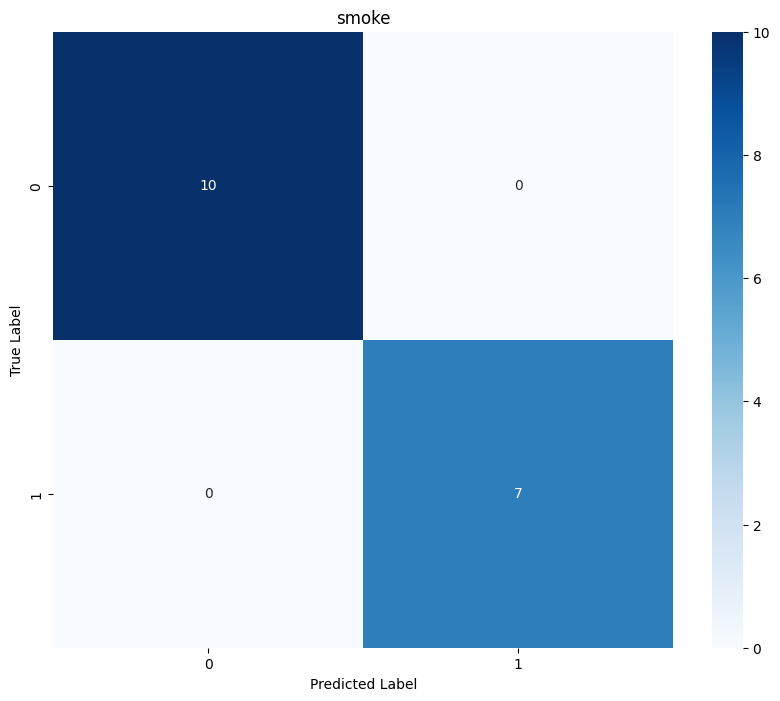

F1 Score: 1.0

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        10
         1.0       1.00      1.00      1.00         7

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



In [22]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 실제 레이블과 예측 레이블을 사용하여 Confusion Matrix를 계산합니다.
conf_matrix = confusion_matrix(y_val, test_pred_idx)

# F1 Score를 계산합니다.
f1 = f1_score(y_val, test_pred_idx, average='weighted')

# Confusion Matrix를 시각화합니다.
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# 모델에 맞게 타이틀 변경하기
plt.title('smoke')
plt.show()

# 결과를 출력합니다.
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_val, test_pred_idx))